## Speed as Rhythm

### Background

Human and animal locomotion establishes a tight connection between movement in space and rhythm. For example, [Laffi et al., 2024](https://nyaspubs.onlinelibrary.wiley.com/doi/full/10.1111/nyas.15271) quantified the rhythmic differences in the temporal structure of horses' walk, trot, and canter, and promised to better explore the connection between rhythmic regularity and locomotor speed. In human-computer interaction, it has been previously shown how it is possible to control the trajectories of objects in the two-dimensional space by producing rhythmic cells [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411), each cell being formed by duplets or triplets of pulses, whose Inter-Onset-Interval (IOI) is inversely proportional to one of the two orthogonal components of velocity. The movement of an object in space can be monitored just by rhythm [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411), or by a combination of rhythm, pitch, and spatialization [Bellino et al., 2024](https://dl.acm.org/doi/abs/10.1145/3678299.3678340). 

In data sonification, pitch and rhythm (or IOI) of sounds can be equally effective for auditorilly graphing time-series data [Guiotto et al., 2024](https://iopscience.iop.org/article/10.3847/1538-3881/ad2943/meta), and rhytm perception can also effectively occur in haptics [Bernard et al., 2022](https://www.nature.com/articles/s41598-022-08152-w). 

With audition, there are opportunities and limits of the use of rhythm for the perception and control of trajectories in space. Namely, humans can segregate concurrent auditory streams [Hermes, 2023](https://link.springer.com/content/pdf/10.1007/978-3-031-25566-3.pdf), and detect and reproduce IOIs and their ratios [Nave et al., 2023](https://www.sciencedirect.com/science/article/pii/S0010027723002688?via%3Dihub). 

It has been shown that the production of rhythmic cells by means of two buttons is suitable for controlling trajectories in space [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411), but the role of auditory feedback in filling blanks of visual information, as trajectories could be imagined as well as deduced from rhythm. In the proposed experiments, we address the specific question of how accurate the perception and production of speed and direction are. 


### Objectives

1. Showing that humans can interpret two overlapping rhythms and reproduce the direction and speed of a moving object, when each of the two rhythms is made to correspond to one of the components of the velocity vector;
2. Showing that it is possible to produce two overlapping rhythms that correspond to a visually perceived linear motion trajectory;
3. Measuring the accuracy and precision of perception and action of rhythmic trajectories, by two tasks of multisensory translation between perception and action.

In [377]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import glob

from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.descriptivestats import sign_test
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import kurtosis
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from scipy.stats import wilcoxon
from scipy.stats import iqr


sns.set(style="darkgrid")


In [330]:
def categorize_angles_into_quadrants(df, angle_column='angle_degrees', quadrant_column='quadrant'):
    """
    Transforms angles in degrees into quadrants (I, II, III, IV) and adds a 
    new column with the quadrant information to the DataFrame.

    Args:
        df: Pandas DataFrame containing an angle column.
        angle_column: Name of the column containing angles in degrees.  Defaults to 'angle_degrees'.
        quadrant_column: Name of the new column to store quadrant information. Defaults to 'quadrant'.

    Returns:
        Pandas DataFrame with the added quadrant column.  Returns the original DataFrame if the angle column is not found.
        Prints an error message if the angle column is not found.
    """

    if angle_column not in df.columns:
        print(f"Error: Angle column '{angle_column}' not found in DataFrame.")
        return df

    df[quadrant_column] = np.nan  # Initialize with NaN (for consistency with NaN angles)

    # Handle NaN angles directly
    nan_mask = df[angle_column].isna()

    # Vectorized operations for non-NaN angles
    valid_mask = ~nan_mask  # Invert the NaN mask

    angles = df.loc[valid_mask, angle_column].astype(float) % 360  # Vectorized modulo

    df.loc[valid_mask & (angles < 90), quadrant_column] = 'I'
    df.loc[valid_mask & (angles >= 90) & (angles < 180), quadrant_column] = 'II'
    df.loc[valid_mask & (angles >= 180) & (angles < 270), quadrant_column] = 'III'
    df.loc[valid_mask & (angles >= 270), quadrant_column] = 'IV'


    return df

In [331]:
def detect_flips(df, quadrant1_col, quadrant2_col, flip_col='flip_type'):
    """
    Detects horizontal, vertical, and double flips based on quadrant changes.

    Args:
        df: Pandas DataFrame containing two quadrant columns.
        quadrant1_col: Name of the first quadrant column.
        quadrant2_col: Name of the second quadrant column.
        flip_col: Name of the new column to store flip information. Defaults to 'flip_type'.

    Returns:
        Pandas DataFrame with the added flip_type column.  Returns original DataFrame if columns are not found.
        Prints error messages if columns are not found.
    """
    
    if quadrant1_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant1_col}' not found in DataFrame.")
        return df

    if quadrant2_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant2_col}' not found in DataFrame.")
        return df

    df[flip_col] = 'N'  # Initialize

    # Create boolean masks for each flip type (vectorized)
    h_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'II')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'III'))

    v_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'II'))

    b_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'II'))

    same_mask = df[quadrant1_col] == df[quadrant2_col]

    nan_mask = df[quadrant1_col].isna() | df[quadrant2_col].isna()

    # Apply masks (vectorized)
    df.loc[h_mask, flip_col] = 'H'
    df.loc[v_mask, flip_col] = 'V'
    df.loc[b_mask, flip_col] = 'B'
    df.loc[same_mask, flip_col] = 'N' # No flip if same
    df.loc[nan_mask, flip_col] = np.nan # NaN if any is NaN

    return df

# Task a
Read all participants' data for task **a**. Add a column with participant number.

In [367]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_a*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [368]:
# rename the columns
df.columns = ['trial', 'soundSpeed', 'soundAngle', 'movSpeed', 'movAngle', 'soundStart', 'startDragTime', 'endDragTime', 'hInterval', 'vInterval', 'nPart']

In [369]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='soundAngle', quadrant_column='soundQuadrant');
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
detect_flips(df, 'soundQuadrant', 'movQuadrant', 'flip')

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip
19,19,37.684478,304.816029,15.552421,335.947471,1740393556366,1740393576186,1740393588649,1394.330718,969.663711,1,IV,IV,N
24,24,28.267477,317.873231,27.334524,319.398705,1740393650899,1740393658815,1740393665898,1430.961216,1582.189494,1,IV,IV,N
25,25,33.835866,126.027625,41.138586,168.690068,1740393670399,1740393680921,1740393685631,1507.430202,1096.322995,1,II,II,N
26,26,72.207546,143.044079,60.287944,142.774601,1740393690131,1740393694073,1740393697281,519.922342,691.065773,1,II,II,N
27,27,30.696642,218.376044,52.092136,230.460213,1740393701782,1740393706405,1740393710114,1246.637830,1574.217141,1,III,III,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,15,69.507615,139.441469,80.513627,157.813322,1741191824491,1741191831856,1741191834257,568.097221,663.782094,20,II,II,N
16,16,76.032558,302.148626,89.727006,288.248924,1741191838758,1741191845085,1741191847256,741.505288,466.022798,20,IV,IV,N
17,17,94.537060,77.109272,83.255622,81.164627,1741191851758,1741191854994,1741191857340,1422.441589,325.540360,20,I,I,N
10,10,103.614743,282.027661,186.233377,274.596808,1741191766591,1741191769201,1741191770273,1389.426473,296.032861,20,IV,IV,N


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 


In [370]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')

# Create a pivot table to fill missing values with 0
pivot_table = errors_df.pivot_table(values='Count', index='nPart', columns='flip', aggfunc='sum', fill_value=0)

means = pivot_table.mean()
print("means = ")
print(means)

stds = pivot_table.std()
print("std = ")
print(stds)


means = 
flip
B     0.1
H     0.2
N    38.1
V     1.6
dtype: float64
std = 
flip
B    0.307794
H    0.523148
N    1.447321
V    1.231174
dtype: float64


In [371]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 38


In [372]:
dfN.tail()

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip
14,14,94.444180,77.813256,76.405201,84.699073,1741191813808,1741191817440,1741191819990,1504.736993,324.971254,20,I,I,N
15,15,69.507615,139.441469,80.513627,157.813322,1741191824491,1741191831856,1741191834257,568.097221,663.782094,20,II,II,N
16,16,76.032558,302.148626,89.727006,288.248924,1741191838758,1741191845085,1741191847256,741.505288,466.022798,20,IV,IV,N
17,17,94.537060,77.109272,83.255622,81.164627,1741191851758,1741191854994,1741191857340,1422.441589,325.540360,20,I,I,N
10,10,103.614743,282.027661,186.233377,274.596808,1741191766591,1741191769201,1741191770273,1389.426473,296.032861,20,IV,IV,N


### Histograms of generated speed and angle. 

TBD: Explain the shapes of the distributions, based on uniform generation of inter-onset intervals along the two axes. 

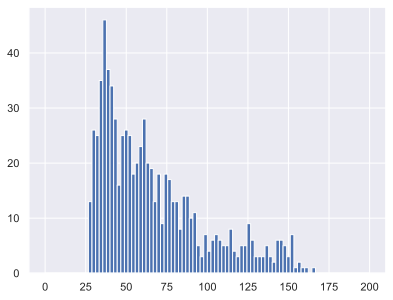

In [373]:
plt.hist(dfN.soundSpeed, bins=90, range = (0, 200));

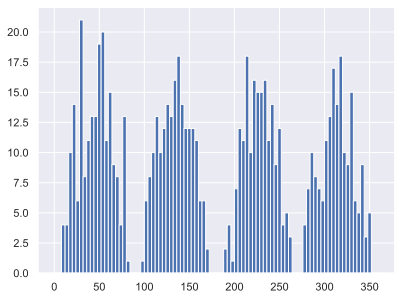

In [374]:
plt.hist(dfN.soundAngle,bins=90, range=(0,360));

### Statistics of angle and speed error

- Normality test
- skewness and kurtosis
- TBD: significance of difference of the means from zero (parametric or non-parametric depending on normality)


In [388]:
errAngle = dfN.movAngle - dfN.soundAngle
print(np.mean(errAngle))
print(np.std(errAngle))
print(np.quantile(errAngle, [0,0.25,0.5,0.75,1]))
print(iqr(errAngle))
# print(errAngle.to_string())

-0.12010458436610644
13.003019172861446
[-47.64144663  -7.63950513  -0.1527576    7.59683043  60.88307738]
15.23633555234997


D'Agostino statistics=32.311, p=0.000
Shapiro-Wilk statistics=0.982, p=0.000
skewness=0.065
kurtosis=1.681


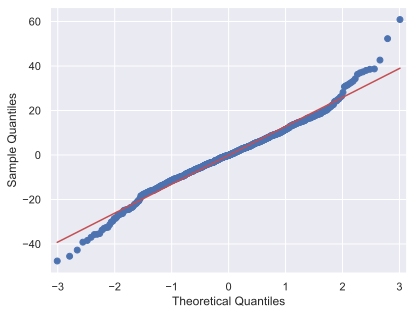

In [389]:
qqplot(errAngle, line='s')
# D'Agostino normality test
stat,p = normaltest(errAngle) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(errAngle) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(errAngle))
print('kurtosis=%.3f' % kurtosis(errAngle))

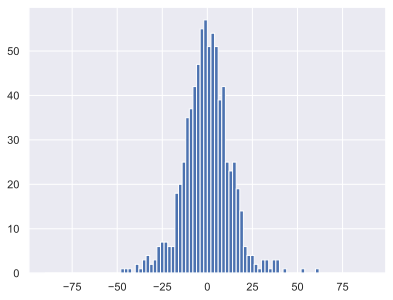

In [390]:
plt.hist(errAngle, bins=90, range = (-90,90));

Ok, the distribution is not normal (fat tails). We can try to trim and distort the distribution to achieve Normality. The following methods have been tried, with no success.

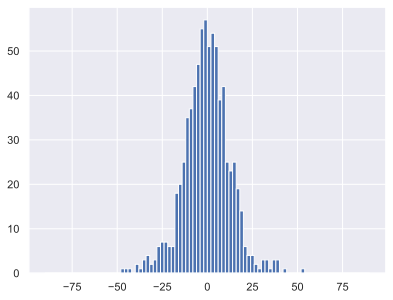

In [382]:
# Data Transformation aiming at normality

# trim values to be smaller than 60 degrees
tanErrAngle = errAngle[errAngle<60]

# tanErrAngle = (np.sin(errAngle/180*np.pi)) 
# tanErrAngle = np.tan(errAngle/180*np.pi)
# tanErrAngle = boxcox(errAngle+90, 0.5)
# tanErrAngle,lam = boxcox(errAngle+90)
# tanErrAngle, lam = yeojohnson(errAngle)

# ----
# data_np = np.array(errAngle)

# 1. Standardization
# mean = np.mean(data_np)
# std = np.std(data_np)
# standardized_data = (data_np - mean) / std

# 2. Square of absolute values
# abs_sqrt_data = (np.abs(standardized_data))**2

# 3. Restore original signs
# tanErrAngle = np.sign(standardized_data) * abs_sqrt_data
# ----

# print(lam)

plt.hist(tanErrAngle, bins=90, range = (-90,90));

D'Agostino statistics=23.158, p=0.000
Shapiro-Wilk statistics=0.986, p=0.000
skewness=-0.055
kurtosis=1.283


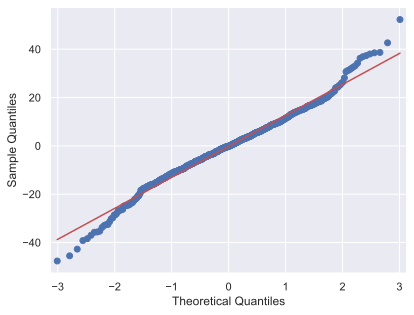

In [383]:
qqplot(tanErrAngle, line='s')
# D'Agostino normality test
stat,p = normaltest(tanErrAngle) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(tanErrAngle) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(tanErrAngle))
print('kurtosis=%.3f' % kurtosis(tanErrAngle))

In [391]:
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(errAngle, 0)
print(stat, p)

# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(errAngle - hypMedian, zero_method='wilcox', correction=False)
print(rank, p)


-5.0 0.7444215806515366
144246.0 0.855675340604174


So, we can not reject the null hypothesis that the median is zero. Although the distribution is not normal, skewness is small, thus indicating a symmetric distribution. 
Precision can be given by the interquartile range, i.e. $15.236$. This can be interpreted as the differential threshold, or just noticeable difference, in angle.

In [393]:
errSpeed = dfN.soundSpeed - dfN.movSpeed
print(np.mean(errSpeed))
print(np.std(errSpeed))
print(np.quantile(errSpeed, [0,0.25,0.5,0.75,1]))
print(iqr(errSpeed))

-12.955674264514284
39.36857503629376
[-471.13854769  -25.1275922    -9.98518953    5.23863187   93.12248043]
30.36622407083801


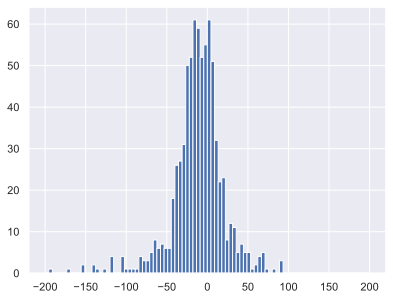

In [394]:
plt.hist(errSpeed, bins=90, range=(-200, 200));

D'Agostino statistics=641.643, p=0.000
Shapiro-Wilk statistics=0.776, p=0.000
skewness=-3.448
kurtosis=30.197


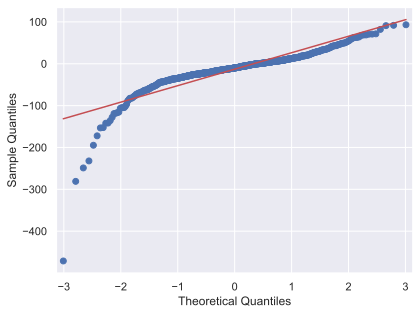

In [395]:
qqplot(errSpeed, line='s')
# D'Agostino normality test
stat,p = normaltest(errSpeed) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(errSpeed) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(errSpeed))
print('kurtosis=%.3f' % kurtosis(errSpeed))

In [396]:
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(errSpeed, 0)
print(stat, p)

# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(errSpeed - hypMedian, zero_method='wilcox', correction=False)
print(rank, p)


-122.0 6.719491295808916e-19
81647.0 1.0566584945891953e-25


We can definitely reject the null hypothesis that the median is zero. The skewness is quite large, and kurtosis is large as well. The median ($-9.985$) can give a measure of accuracy. Precision, on the other hand, can be given by the interquartile range, i.e. $30.366$. This can be interpreted as the differential threshold, or just noticeable difference, in speed.

Do participant think longer when they have smaller errors? Apparently not.

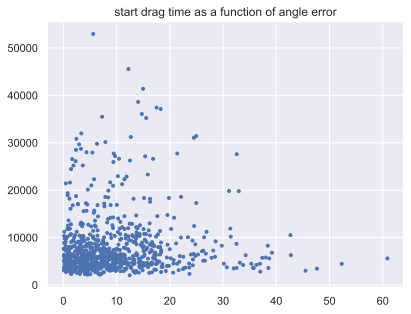

In [308]:
fig, ax = plt.subplots()
ax.plot(abs(errAngle), abs(dfN.startDragTime-dfN.soundStart), '.')
ax.set_title('start drag time as a function of angle error');

# Task b
Read all participants' data for task **b**. Add a column with participant number.

In [397]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_b*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [398]:
# rename the columns
df.columns = ['trial', 'movSpeed', 'movAngle', 'tapSpeed', 'tapAngle', 'movStart', 'tapHor', 'tapVer', 'tapHor2', 'tapVer2', 'hInterval', 'vInterval', 'nPart']

In [399]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
categorize_angles_into_quadrants(df, angle_column='tapAngle', quadrant_column='tapQuadrant');
detect_flips(df, 'movQuadrant', 'tapQuadrant', 'flip')

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip
38,38,29.069538,139.792341,18.510638,148.937093,1740394576071,1740394590426,1740394584867,1740394592318,1740394588008,1351.309406,1598.625247,1,II,II,N
15,15,47.295864,154.388125,30.871862,127.869972,1740394327691,1740394330588,1740394334477,1740394332171,1740394335708,703.421001,1467.372329,1,II,II,N
14,14,31.558088,134.454512,36.150549,133.707467,1740394315892,1740394322676,1740394319730,1740394323877,1740394320878,1357.375186,1331.772242,1,II,II,N
13,13,77.480473,342.555969,67.151947,340.139432,1740394306524,1740394308565,1740394310764,1740394309040,1740394312079,405.859724,1291.620691,1,IV,IV,N
12,12,32.529874,42.008159,26.163425,44.258234,1740394295225,1740394301120,1740394298062,1740394302721,1740394299705,1241.140979,1378.032018,1,I,I,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,14,138.820469,65.656067,109.941678,53.150256,1741191186673,1741191194739,1741191191888,1741191195194,1741191192229,524.259097,237.196171,20,I,I,N
15,15,74.018834,158.122704,51.863848,157.301473,1741191199007,1741191205837,1741191202797,1741191206464,1741191204296,436.755652,1087.709087,20,II,II,N
16,16,53.399478,317.429087,44.009027,336.737338,1741191210273,1741191218437,1741191214920,1741191219179,1741191216646,762.862920,830.452958,20,IV,IV,N
9,9,92.749237,200.641512,36.119262,148.705422,1741191122743,1741191133175,1741191130539,1741191134147,1741191132138,345.641464,917.545167,20,III,II,V


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 

TBD: test for significance of the difference in total number of flips in the two tasks A and B

In [400]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')

# Create a pivot table to fill missing values with 0
pivot_table = errors_df.pivot_table(values='Count', index='nPart', columns='flip', aggfunc='sum', fill_value=0)

means = pivot_table.mean()
print("means = ")
print(means)

stds = pivot_table.std()
print("std = ")
print(stds)


means = 
flip
H     0.1
N    39.5
V     0.4
dtype: float64
std = 
flip
H    0.307794
N    0.827170
V    0.680557
dtype: float64


In [401]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 10


In [402]:
dfN.tail()

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip
13,13,64.367225,207.666240,34.939732,214.189027,1741191175307,1741191181820,1741191178495,1741191182858,1741191180023,526.242386,1003.780659,20,III,III,N
14,14,138.820469,65.656067,109.941678,53.150256,1741191186673,1741191194739,1741191191888,1741191195194,1741191192229,524.259097,237.196171,20,I,I,N
15,15,74.018834,158.122704,51.863848,157.301473,1741191199007,1741191205837,1741191202797,1741191206464,1741191204296,436.755652,1087.709087,20,II,II,N
16,16,53.399478,317.429087,44.009027,336.737338,1741191210273,1741191218437,1741191214920,1741191219179,1741191216646,762.862920,830.452958,20,IV,IV,N
39,39,56.230280,236.645440,43.161428,231.189298,1741191483474,1741191494304,1741191489578,1741191495413,1741191490470,970.357306,638.729173,20,III,III,N


### Histograms of generated speed and angle.

TBD Explain the shapes of the distributions, based on uniform generation of inter-onset intervals along the two axes.


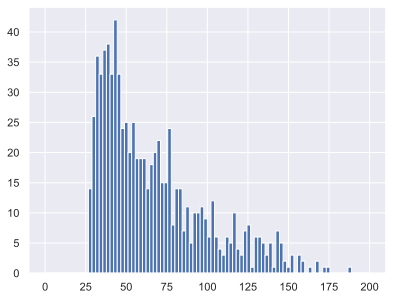

In [403]:
plt.hist(df.movSpeed, bins=90, range=(0, 200));

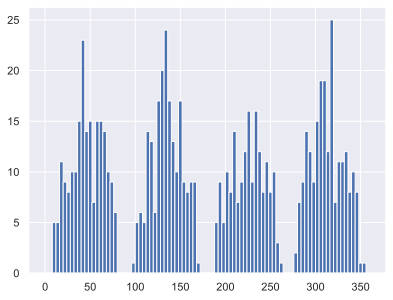

In [404]:
plt.hist(dfN.movAngle,bins=90, range=(0,360));

### Statistics of angle and speed error

- Normality test
- skewness and kurtosis
- TBD: significance of difference of the means from zero (parametric or non-parametric depending on normality)


In [405]:
errAngle = dfN.tapAngle - dfN.movAngle
print(np.mean(errAngle))
print(np.std(errAngle))
print(np.quantile(errAngle, [0,0.25,0.5,0.75,1]))
print(iqr(errAngle))
# print(errAngle.to_string())

0.16464207238111606
12.573791197290275
[-43.07214903  -7.61908786   0.0687017    7.47624921  54.57127197]
15.095337066988169


D'Agostino statistics=52.710, p=0.000
Shapiro-Wilk statistics=0.979, p=0.000
skewness=0.367
kurtosis=1.810


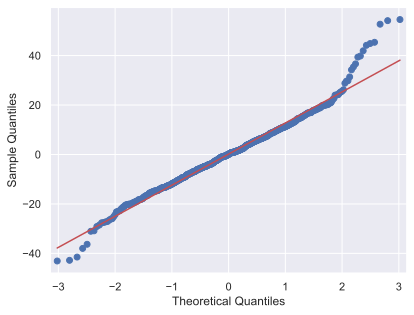

In [406]:
qqplot(errAngle, line='s')
# D'Agostino normality test
stat,p = normaltest(errAngle) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(errAngle) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(errAngle))
print('kurtosis=%.3f' % kurtosis(errAngle))

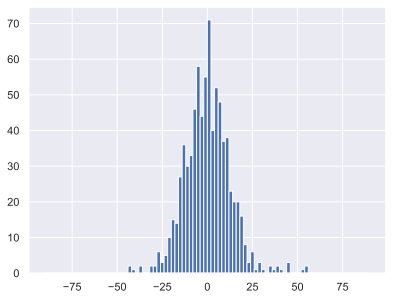

In [407]:
plt.hist(errAngle, bins=90, range=(-90,90));

In [408]:
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(errAngle, 0)
print(stat, p)

# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(errAngle - hypMedian, zero_method='wilcox', correction=False)
print(rank, p)

4.0 0.8033421130139473
155829.0 0.9510953116282331


So, we can not reject the null hypothesis that the median is zero. Although the distribution is not normal, skewness is relatively small, thus indicating a symmetric distribution. Precision can be given by the interquartile range, i.e. $15.095$. This can be interpreted as the differential threshold, or just noticeable difference, in angle.

13.033248729090545
26.16883952364156
[-78.43793091  -0.66687841  10.04097559  25.10869426 114.90742663]
25.775572672886387


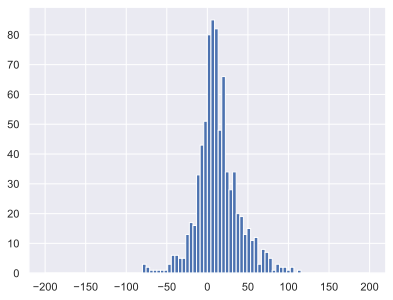

In [411]:
errSpeed = dfN.movSpeed - dfN.tapSpeed
print(np.mean(errSpeed))
print(np.std(errSpeed))
print(np.quantile(errSpeed, [0,0.25,0.5,0.75,1]))
print(iqr(errSpeed))
plt.hist(errSpeed, bins=90, range=(-200,200));

D'Agostino statistics=45.946, p=0.000
Shapiro-Wilk statistics=0.966, p=0.000
skewness=0.322
kurtosis=1.676


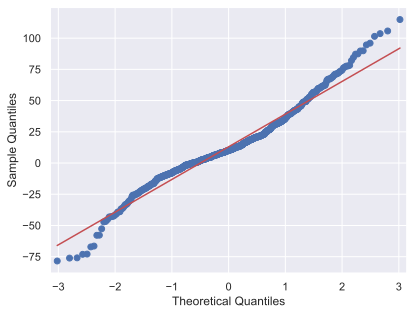

In [412]:
qqplot(errSpeed, line='s')
# D'Agostino normality test
stat,p = normaltest(errSpeed) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(errSpeed) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(errSpeed))
print('kurtosis=%.3f' % kurtosis(errSpeed))

In [413]:
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(errSpeed, 0)
print(stat, p)

# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(errSpeed - hypMedian, zero_method='wilcox', correction=False)
print(rank, p)


187.0 9.315455466944132e-42
67069.0 6.738704523206971e-44


We can definitely reject the null hypothesis that the median is zero. The skewness is relatively small, and kurtosis is quite large. The median (-10.041) can give a measure of accuracy. Precision, on the other hand, can be given by the interquartile range, i.e. $25.776$. This can be interpreted as the differential threshold, or just noticeable difference, in speed.

Do participant think longer when they have smaller errors? Apparently not.

Text(0.5, 1.0, 'start tapping time as a function of angle error')

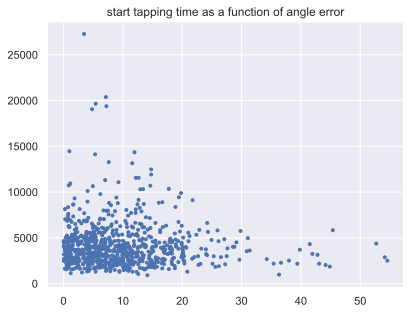

In [414]:
fig, ax = plt.subplots()
ax.plot(abs(errAngle), abs(dfN[['tapHor','tapVer']].min(axis=1) - dfN.movStart ), '.')
ax.set_title('start tapping time as a function of angle error')

### TBD
- regression of speed error vs stimulus angle (deviation from diagonal)
- regression of angle error vs stimulus angle (deviation from diagonal)

### TBD
Comparison of speed and angle error between Task A and Task B

### TBD
Analysis of relative speed error (percent error)

### TBD

Analysis of questionnaires, as in [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411)